- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

In [1]:
import os

In [2]:
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/saved_models', exist_ok=True)

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Embedding
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [11]:
class CGAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        # Input shape, NHWC
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        self.d_inner_model = None
        self.discriminator = None
        self.g_inner_model = None
        self.generator = None

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()
        self.g_inner_model = model

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])

        img = self.g_inner_model(model_input)

        model2 = Model([noise, label], img)

        return model2

    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        #model.summary()
        self.d_inner_model = model

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = self.d_inner_model(model_input)

        model2 = Model([img, label], validity)

        return model2

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print(datetime.datetime.now().isoformat(), '%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1

        fig.savefig('data/images/%d.png' % epoch)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()

In [12]:
cgan = CGAN()

In [13]:
cgan.train(epochs=100, batch_size=32, sample_interval=50)

2020-07-22T14:35:20.163207 0 [D loss: 0.695578, acc.: 25.00%] [G loss: 0.684776]
2020-07-22T14:35:23.251386 50 [D loss: 0.022274, acc.: 100.00%] [G loss: 4.583781]


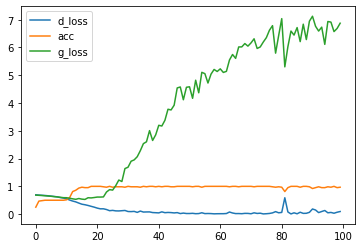

In [14]:
cgan.plot_hisotry()

In [15]:
cgan.train(epochs=900, batch_size=32, sample_interval=100)

2020-07-22T14:37:36.215943 0 [D loss: 0.134787, acc.: 93.75%] [G loss: 6.379035]
2020-07-22T14:37:42.011309 100 [D loss: 0.275267, acc.: 89.06%] [G loss: 5.441358]
2020-07-22T14:37:47.796123 200 [D loss: 0.253738, acc.: 89.06%] [G loss: 3.447340]
2020-07-22T14:37:53.694992 300 [D loss: 0.440365, acc.: 75.00%] [G loss: 2.429133]
2020-07-22T14:37:59.562688 400 [D loss: 0.563590, acc.: 62.50%] [G loss: 1.739492]
2020-07-22T14:38:05.482326 500 [D loss: 0.415785, acc.: 79.69%] [G loss: 1.912078]
2020-07-22T14:38:11.420520 600 [D loss: 0.456257, acc.: 81.25%] [G loss: 1.668269]
2020-07-22T14:38:17.444882 700 [D loss: 0.537950, acc.: 67.19%] [G loss: 1.757503]
2020-07-22T14:38:24.539588 800 [D loss: 0.568144, acc.: 65.62%] [G loss: 1.527674]


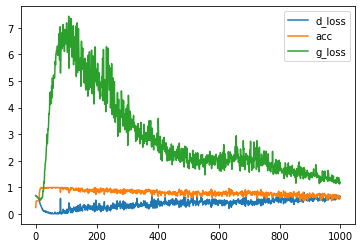

In [16]:
cgan.plot_hisotry()

In [17]:
cgan.train(epochs=2000, batch_size=32, sample_interval=500)

2020-07-22T14:39:52.593114 0 [D loss: 0.589363, acc.: 71.88%] [G loss: 1.361535]
2020-07-22T14:40:21.634526 500 [D loss: 0.683670, acc.: 51.56%] [G loss: 0.922884]
2020-07-22T14:40:52.355693 1000 [D loss: 0.629781, acc.: 65.62%] [G loss: 0.961780]
2020-07-22T14:41:23.063387 1500 [D loss: 0.657034, acc.: 51.56%] [G loss: 0.839578]


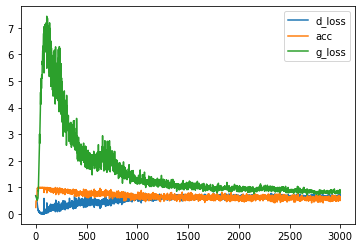

In [18]:
cgan.plot_hisotry()

In [19]:
cgan.sample_images(2000)

2020-07-22T14:46:27.797756 0 [D loss: 0.650248, acc.: 59.38%] [G loss: 0.844421]
2020-07-22T14:47:27.438652 1000 [D loss: 0.651325, acc.: 65.62%] [G loss: 0.820333]
2020-07-22T14:48:29.617828 2000 [D loss: 0.689704, acc.: 56.25%] [G loss: 0.829134]
2020-07-22T14:49:29.422522 3000 [D loss: 0.751870, acc.: 43.75%] [G loss: 0.766366]
2020-07-22T14:50:30.203411 4000 [D loss: 0.683856, acc.: 51.56%] [G loss: 0.777020]
2020-07-22T14:51:30.102470 5000 [D loss: 0.687442, acc.: 48.44%] [G loss: 0.744038]
2020-07-22T14:52:29.521099 6000 [D loss: 0.607431, acc.: 68.75%] [G loss: 0.749621]


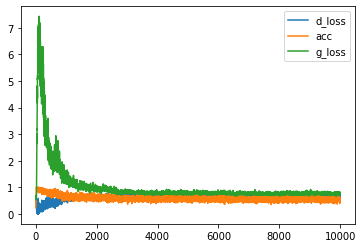

In [20]:
cgan.train(epochs=7000, batch_size=32, sample_interval=1000)
cgan.sample_images(7000)
cgan.plot_hisotry()